1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import torch
from torchvision import transforms , datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
# from q1_helper_code import get_files
import torch.nn.functional as F
import copy

In [297]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [298]:
class AddNoise(object):
    def __init__(self, mean=0., std=0.5):
        self.mean = mean
        self.std = std
        
    def __call__(self, x):
        noise = torch.randn(x.size()) * self.std + self.mean
        return x + noise
        
transform = transforms.Compose([AddNoise()])

In [299]:
mnist_data = datasets.MNIST(root='data/', download=True,train=True, transform=transforms.ToTensor())

In [300]:
batch_size = 256
train_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

In [301]:
class Encoder(nn.Module):

	def __init__(self, num_classes):
		super().__init__()
		self.network = nn.Sequential(
		nn.Conv2d(1, 8, 3, stride=2, padding=1),
    nn.ReLU(inplace=True),
		nn.Conv2d(8, 16, 3, stride=2, padding=1),
		nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
		nn.Conv2d(16, 32, 3, stride=2, padding=0),
    nn.ReLU(inplace=True),
		nn.Flatten(),
		nn.Linear(288, 128),
		nn.ReLU(inplace=True),
		nn.Linear(128, num_classes)
		)

	def forward(self, x):
		return self.network(x)

In [302]:
class Decoder(nn.Module):

	def __init__(self, in_channels):
		super().__init__()
		self.network = nn.Sequential(
			nn.Linear(in_channels, 128),
    	nn.ReLU(inplace=True),
			nn.Linear(128, 288),
    	nn.ReLU(inplace=True),
			nn.Unflatten(dim=1,unflattened_size=(32, 3, 3)),
	 		nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
			nn.BatchNorm2d(16),
    	nn.ReLU(inplace=True),
			nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
			nn.BatchNorm2d(8),
    	nn.ReLU(inplace=True),
			nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
	 		)

	def forward(self, x):
		x = self.network(x)
		x = torch.sigmoid(x)
		return x

In [303]:
encoder = Encoder(num_classes=4)
decoder = Decoder(in_channels=4)

In [304]:
learning_rate = 0.001 
epoch_num = 30
loss = nn.MSELoss()
optimizer = torch.optim.Adam((list(encoder.parameters()) + list(decoder.parameters())),lr=learning_rate)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [305]:
def train_autoencoder(encoder, decoder, trainloader, f_loss, optimizer,n_epochs,device=device):
  for epoch in range(n_epochs):
    encoder.train()
    decoder.train()
    for x,y in trainloader:
      x_noise = transform(x)
      x = x.to(device)
      x_noise = x_noise.to(device)
      after_decode = decoder(encoder(x_noise))
      batch_loss = f_loss(after_decode, x)
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

In [306]:
train_autoencoder(encoder, decoder, train_loader, loss, optimizer,epoch_num)

In [307]:
mnist_data_test = datasets.MNIST(root='data/', download=True,train=False, transform=transforms.ToTensor())
mnist_data_test_np = mnist_data_test.targets.numpy()
test_loader = DataLoader(mnist_data_test, batch_size=batch_size,shuffle=True)
def plot_results(encoder,decoder):
	for i in range(10):
		possible_choices = np.where(mnist_data_test_np==i)
		rand = random.randint(0,len(possible_choices)-1)
		image = mnist_data_test[possible_choices[rand][rand]][0].unsqueeze(0)
		noised_image = transform(image).to(device)
		encoder.eval()
		decoder.eval()
		with torch.no_grad():
			autoencoded = decoder(encoder(noised_image))
		plt.figure(figsize=(2,2))
		plt.subplot(1, 3, 1)
		plt.imshow(image.cpu().squeeze().numpy(), cmap='gist_gray')
		plt.axis('off')
		plt.subplot(1, 3, 2)
		plt.imshow(noised_image.cpu().squeeze().numpy(), cmap='gist_gray')
		plt.axis('off')
		plt.subplot(1, 3, 3)
		plt.imshow(autoencoded.cpu().squeeze().numpy(), cmap='gist_gray')
		plt.axis('off')
		plt.show()

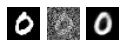

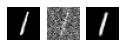

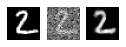

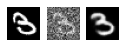

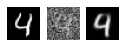

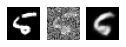

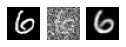

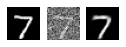

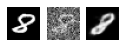

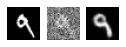

In [308]:
plot_results(encoder,decoder)